In [102]:
import pandas as pd
import comet_ml


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from  decouple import Config,RepositoryEnv
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler


config = Config(RepositoryEnv(".env"))

In [105]:
def iniate_comet():
    experiment = comet_ml.Experiment(
  api_key= config("COMET_API"),
  project_name=config("PROJECT_NAME"),
  workspace=config("WORKSPACE")
)
    return experiment
    
experiment = iniate_comet()
    

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dataspelunker/sparkify/1f63dba3e92b406d8a3e7894dc8772af



In [107]:

def normalize_dataframe(df, columns_to_normalize=None):
    if columns_to_normalize is None:
        columns_to_normalize = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    return df

def plot_conf_matrix(y_test,preds):
    cm = confusion_matrix(y_test,preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [108]:

# Read the CSV file into a DataFrame
file_path = "/Users/jacobfletcher/git/churn_project/data/processed_features_2024-01-17 22:27:23.554129.csv"
df = pd.read_csv(file_path)

# Drop the 'Unnamed: 0' column
df = df.drop(['Unnamed: 0'], axis=1)
df = df.fillna(0)
df = df.drop('userId', axis=1)
print(df.shape)
df['label'].value_counts()

(22249, 41)


label
0    17247
1     5002
Name: count, dtype: int64

In [109]:
df.columns

Index(['label', 'count', 'avg_daily_listens', 'level_flag', 'pos_interactions',
       'neg_interactions', 'unique_locations', 'distinct_artist', 'About',
       'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home',
       'Login', 'Logout', 'Register', 'Roll Advert', 'Save Settings',
       'Settings', 'Submit Downgrade', 'Submit Registration', 'Submit Upgrade',
       'Thumbs Down', 'Thumbs Up', 'Upgrade', 'device_iOS', 'device_Linux',
       'device_Other', 'device_Ubuntu', 'device_Mac OS X', 'device_Windows',
       'browser_Firefox', 'browser_Safari', 'browser_Other',
       'browser_Chromium', 'browser_Google', 'browser_Mobile Safari',
       'browser_IE', 'browser_Chrome'],
      dtype='object')

In [110]:

# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], train_size=0.8)

X_test = normalize_dataframe(X_test)
X_train = normalize_dataframe(X_train)


In [111]:
param_grid = {
    'n_estimators': [50, 100, 200,300,350],
    'max_depth': [None, 10, 20,25,30],
    'min_samples_split': [1,2, 5, 10,15,20],
}




In [112]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

cv = 5
scoring = "f1"


# Create GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid=param_grid,scoring=scoring, cv=cv, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_rf_classifier = grid_search.best_estimator_
preds = best_rf_classifier.predict(X_test)

/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
125 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.1

In [113]:
best_params = grid_search.best_params_
print(best_params)
print(classification_report(preds,y_test))

{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4208
           1       0.14      0.60      0.23       242

    accuracy                           0.78      4450
   macro avg       0.56      0.69      0.55      4450
weighted avg       0.93      0.78      0.84      4450



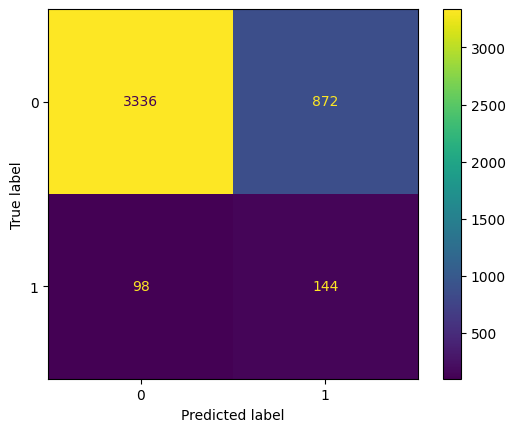

In [114]:
cm = confusion_matrix(preds,y_test)
ConfusionMatrixDisplay(cm).plot()


In [115]:
f1 = f1_score(y_pred=preds, y_true=y_test)
precision = precision_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_pred=preds, y_true=y_test)
metrics = {"f1": f1, "recall": recall, "precision": precision}

print(metrics)


params = {
    "param_grid": str(param_grid),
    "best_param": best_params,
    "model_type": "Random Forrest",
    "Cross Validation": cv,
    "scoring": scoring,
    "data_source": file_path
}

{'f1': 0.2289348171701113, 'recall': 0.14173228346456693, 'precision': 0.5950413223140496}


In [116]:

experiment.log_metrics(metrics)
experiment.log_parameters(params)
experiment.log_confusion_matrix(
    y_true = y_test.tolist(),
    y_predicted = preds.tolist(),
    step=0,
    title="Confusion Matrix",
    file_name="confusion-matrix-%03d.json" % 0,
);


In [117]:

experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dataspelunker/sparkify/1f63dba3e92b406d8a3e7894dc8772af
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.2289348171701113
COMET INFO:     precision : 0.5950413223140496
COMET INFO:     recall    : 0.14173228346456693
COMET INFO:   Others:
COMET INFO:     hasNestedParams : True
COMET INFO:   Parameters:
COMET INFO:     Cross Validation             : 5
COMET INFO:     best_param|max_depth         : 25
COMET INFO:     best_param|min_samples_split : 2
COMET INFO:     best_param|n_estimators      : 50
COMET INFO:     data_source                  : /Users/jacobfletcher/git/churn_project/data/processed_features_2024-01-17 22:27:23.